# UCI Irvine Diabetes Dataset AIM94

# 1.Read data

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau  
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import LearningRateScheduler  
from sklearn.model_selection import KFold  
from lifelines.utils import datetimes_to_durations

In [2]:
df= pd.read_csv("C:\\Users\\Hp\\Downloads\\blood_glucose.csv")
df

,Unnamed: 0,id,date,time,code,value,val
0,0,1,04-21-1991,9:09,58,100,100.0
1,3,1,04-21-1991,17:08,62,119,119.0
2,5,1,04-21-1991,22:51,48,123,123.0
3,6,1,04-22-1991,7:35,58,216,216.0
4,10,1,04-22-1991,16:56,62,211,211.0
...,...,...,...,...,...,...,...
13637,29314,70,05-07-1989,12:00,60,151,151.0
13638,29317,70,05-07-1989,22:00,48,265,265.0
13639,29318,70,05-08-1989,08:00,58,248,248.0
13640,29323,70,05-08-1989,22:00,48,145,145.0


# 2. Preprocess the Data

## a.Filter and Clean Data

In [3]:
df.dtypes

Unnamed: 0      int64
id              int64
date           object
time           object
code            int64
value           int64
val           float64
dtype: object

###
Cannot convert values to_numeric() here because some of them are things like "hi" and "lo". Need to filter down to blood glucose measurements first.

Key to code fields below. Note that we have categorical variables in this dataset (hypoglycemic symptoms, etc.). The Code field is deciphered as follows:

33 = Regular insulin dose

34 = NPH insulin dose

35 = UltraLente insulin dose

48 = Unspecified blood glucose measurement

57 = Unspecified blood glucose measurement

58 = Pre-breakfast blood glucose measurement

59 = Post-breakfast blood glucose measurement

60 = Pre-lunch blood glucose measurement

61 = Post-lunch blood glucose measurement

62 = Pre-supper blood glucose measurement

63 = Post-supper blood glucose measurement

64 = Pre-snack blood glucose measurement

65 = Hypoglycemic symptoms

66 = Typical meal ingestion

67 = More-than-usual meal ingestion

68 = Less-than-usual meal ingestion

69 = Typical exercise activity

70 = More-than-usual exercise activity

71 = Less-than-usual exercise activity

72 = Unspecified special event

### Filter down to blood glucose measurements only.

In [4]:
# blood_glucose = df[(df['code'] >= 58) & (df['code'] <= 68)]
# blood_glucose.head()

In [5]:
blood_glucose = df
blood_glucose.head()

,Unnamed: 0,id,date,time,code,value,val
0,0,1,04-21-1991,9:09,58,100,100.0
1,3,1,04-21-1991,17:08,62,119,119.0
2,5,1,04-21-1991,22:51,48,123,123.0
3,6,1,04-22-1991,7:35,58,216,216.0
4,10,1,04-22-1991,16:56,62,211,211.0


In [6]:
blood_glucose.shape

(13642, 7)

In [7]:
# Convert 'value' to numeric, handle non-numeric values as NaN
blood_glucose['value'] = pd.to_numeric(blood_glucose['value'], errors='coerce')

### b.clean up that dirty data

In [8]:
blood_glucose = blood_glucose[blood_glucose['value'].notnull()]

In [9]:
# blood_glucose['date'] = pd.to_datetime(blood_glucose['date'] , errors='coerce')
# # # Extract the day part
# # blood_glucose['day'] = blood_glucose['date'].dt.day
# # Convert 'time' column to datetime
# blood_glucose['time'] = pd.to_datetime(blood_glucose['time'], errors='coerce')

# # Convert 'time' to hours and minutes format "HH:MM"
# blood_glucose['time'] = blood_glucose['time'].dt.hour


In [10]:
# Step 1: Combine 'date' and 'time' into a single 'datetime' column without specifying format
blood_glucose['datetime'] = pd.to_datetime(
    blood_glucose['date'] + ' ' + blood_glucose['time'], errors='coerce'
)

# # Check for any failed conversions
# print(blood_glucose[blood_glucose['datetime'].isna()])




# # # Step 2: Extract the hour from the 'datetime' column
# # blood_glucose['hour'] = blood_glucose['datetime'].dt.hour

In [11]:
# meal_context_map =  {
#         33: 'regular_insulin_dose',
#         34: 'nph_insulin_dose',
#         35: 'ultralente_insulin_dose',
#         48: 'unspecified_blood_glucose',
#         57: 'unspecified_blood_glucose',
#         58: 'pre_breakfast',
#         59: 'post_breakfast',
#         60: 'pre_lunch',
#         61: 'post_lunch',
#         62: 'pre_supper',
#         63: 'post_supper',
#         64: 'pre_snack',
#         65: 'hypoglycemic_symptoms',
#         66: 'typical_meal',
#         67: 'large_meal',
#         68: 'small_meal',
#         69: 'typical_exercise',
#         70: 'more_than_usual_exercise',
#         71: 'less_than_usual_exercise',
#         72: 'unspecified_special_event'
#     }

# # Add meal context column
# blood_glucose['meal_context'] = blood_glucose['code'].map(meal_context_map)

In [12]:
# Check for missing values
print("Missing values:")
print(blood_glucose.isnull().sum())

Missing values:
Unnamed: 0    0
id            0
date          0
time          0
code          0
value         0
val           0
datetime      5
dtype: int64


In [13]:
# Drop rows with missing datetime values
blood_glucose = blood_glucose.dropna()
# Check for missing values
print("Missing values:")
print(blood_glucose.isnull().sum())

Missing values:
Unnamed: 0    0
id            0
date          0
time          0
code          0
value         0
val           0
datetime      0
dtype: int64


In [14]:
print(blood_glucose.dtypes)


Unnamed: 0             int64
id                     int64
date                  object
time                  object
code                   int64
value                  int64
val                  float64
datetime      datetime64[ns]
dtype: object


In [15]:
blood_glucose.drop(['val','date','time','id','Unnamed: 0'], axis=1, inplace=True)

In [16]:
# # Step 3: Classification function based on 'code' and 'value'
# def classify_glucose(row):
#     value = row['value']
#     code = row['code']

#     if code in [59, 61, 63]:  # Post-meal (0-2 hours)
#         if value >= 300:
#             return 'Dangerous'
#         elif 140 <= value <= 220:
#             return 'High'
#         elif 90 <= value < 140:
#             return 'Normal'
#         elif 80 <= value < 90:
#             return 'Low'
#         else:
#             return 'Dangerous'

#     elif code in [58, 60, 62]:  # Pre-meal (2-4 hours)
#         if value >= 200:
#             return 'Dangerous'
#         elif 130 <= value < 200:
#             return 'High'
#         elif 90 <= value < 130:
#             return 'Normal'
#         elif 70 <= value < 90:
#             return 'Low'
#         else:
#             return 'Dangerous'

#     elif code in [64, 66, 67, 68]:  # Longer durations (4-8 hours)
#         if value >= 180:
#             return 'Dangerous'
#         elif 120 <= value < 180:
#             return 'High'
#         elif 80 <= value < 120:
#             return 'Normal'
#         elif 60 <= value < 80:
#             return 'Low'
#         else:
#             return 'Dangerous'

#     else:  # Unknown context (8+ hours)
#         if value >= 180:
#             return 'Dangerous'
#         elif 120 <= value < 180:
#             return 'High'
#         elif 80 <= value < 120:
#             return 'Normal'
#         elif 60 <= value < 80:
#             return 'Low'
#         else:
#             return 'Dangerous'

# # Apply classification
# blood_glucose['classification'] = blood_glucose.apply(classify_glucose, axis=1)



# # Create an event column (1 if the glucose value exceeds a certain threshold)
# threshold = 180  # You can change this threshold based on your definition of an event
# blood_glucose['event'] = (blood_glucose['value'] >= threshold).astype(int)

# Check for NaNs in the DataFrame
print("Checking for NaNs in the dataset:")
print(blood_glucose.isnull().sum())


# Step 5: Display the DataFrame with classifications
print(blood_glucose[['datetime' ,'value', 'code']])

Checking for NaNs in the dataset:
code        0
value       0
datetime    0
dtype: int64
                 datetime  value  code
0     1991-04-21 09:09:00    100    58
1     1991-04-21 17:08:00    119    62
2     1991-04-21 22:51:00    123    48
3     1991-04-22 07:35:00    216    58
4     1991-04-22 16:56:00    211    62
...                   ...    ...   ...
13637 1989-05-07 12:00:00    151    60
13638 1989-05-07 22:00:00    265    48
13639 1989-05-08 08:00:00    248    58
13640 1989-05-08 22:00:00    145    48
13641 1989-05-09 08:00:00    259    58

[13637 rows x 3 columns]


In [17]:
# blood_glucose.set_index('datetime', inplace=True)

In [18]:
blood_glucose

,code,value,datetime
0,58,100,1991-04-21 09:09:00
1,62,119,1991-04-21 17:08:00
2,48,123,1991-04-21 22:51:00
3,58,216,1991-04-22 07:35:00
4,62,211,1991-04-22 16:56:00
...,...,...,...
13637,60,151,1989-05-07 12:00:00
13638,48,265,1989-05-07 22:00:00
13639,58,248,1989-05-08 08:00:00
13640,48,145,1989-05-08 22:00:00


In [19]:
# from sklearn.preprocessing import LabelEncoder

In [20]:
# # Encode categorical features
# label_encoder = LabelEncoder()
# encoded_labels = label_encoder.fit_transform(blood_glucose['meal_context'])

# # تحديد عدد البتات المطلوب لتمثيل الأعداد الثنائية
# num_bits = len(bin(max(encoded_labels))) - 2  

# # تحويل الأرقام إلى مصفوفات ثنائية
# binary_labels = np.array([list(map(int, format(label, f'0{num_bits}b'))) for label in encoded_labels])

# # تحويل المصفوفة إلى أعمدة مستقلة
# binary_df = pd.DataFrame(binary_labels, columns=[f'meal_bit_{i}' for i in range(num_bits)])

# # دمج الأعمدة الجديدة مع الجدول الأصلي
# blood_glucose = pd.concat([blood_glucose, binary_df], axis=1).drop(columns=['meal_context'])

# # طباعة النتيجة
# print(blood_glucose)

In [21]:
blood_glucose.drop(['code'], axis=1, inplace=True)
blood_glucose.head()

,value,datetime
0,100,1991-04-21 09:09:00
1,119,1991-04-21 17:08:00
2,123,1991-04-21 22:51:00
3,216,1991-04-22 07:35:00
4,211,1991-04-22 16:56:00


In [22]:
blood_glucose.set_index('datetime', inplace= True)

In [23]:
dataset = blood_glucose["value"]
dataset = pd.DataFrame(dataset)

data = dataset.values

data.shape

(13637, 1)

In [24]:
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [25]:
time_steps=16

In [26]:
# 75% to Train , 25% to Test
train_size = int(len(data)*.75)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]
test_data = scaled_data[ train_size-time_steps: , 0:1 ]

Train Size : 10227 Test Size : 3410


In [27]:
train_data.shape, test_data.shape

((10227, 1), (3426, 1))

In [28]:
# Creating a Training set with 60 time-steps and 1 output
x_train = []
y_train = []

for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, 0])
    y_train.append(train_data[i, 0])

In [29]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [30]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [31]:
x_train.shape , y_train.shape

((10211, 16, 1), (10211,))

In [32]:
import joblib
# حفظ الـ Scaler لاستخدامه لاحقًا في التطبيق
joblib.dump(scaler, "C:\\Users\\Hp\\Desktop\\tracking\\scaler1.pkl")

print("تم حفظ scaler.pkl بنجاح!")

تم حفظ scaler.pkl بنجاح!


In [33]:
from tensorflow.keras.layers import GRU
model = Sequential([
    GRU(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    GRU(64, return_sequences=False),
    Dense(32),
    Dense(16),
    Dense(1)
])


# Compile the model  
model.compile(optimizer="adam", loss='mse',metrics=["mean_absolute_error"])
model.summary()

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 16, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,847 (128.31 KB)

 Trainable params: 32,847 (128.31 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Early stopping and learning rate reduction  
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)  



# Fit the model with callbacks  
history = model.fit(x_train, y_train,  
                    validation_split=0.1,  
                    epochs=100, 
                    batch_size=8,  
                    callbacks=[early_stopping, reduce_lr])  

Epoch 1/100


1149/1149 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0223 - mean_absolute_error: 0.1171 - val_loss: 0.0218 - val_mean_absolute_error: 0.1202 - learning_rate: 0.0010
Epoch 2/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0208 - mean_absolute_error: 0.1146 - val_loss: 0.0212 - val_mean_absolute_error: 0.1175 - learning_rate: 0.0010
Epoch 3/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0204 - mean_absolute_error: 0.1141 - val_loss: 0.0209 - val_mean_absolute_error: 0.1155 - learning_rate: 0.0010
Epoch 4/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0201 - mean_absolute_error: 0.1127 - val_loss: 0.0211 - val_mean_absolute_error: 0.1166 - learning_rate: 0.0010
Epoch 5/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0208 - mean_absolute_error: 0.1143 - val_loss: 0.0210 - val_mean_absolute_error: 0.1150 - learning_rate: 0.0010
Epoch 6/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0208 - mean_absolute_error: 0.1137 - val_loss: 0.021

In [35]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [36]:
x_test.shape , y_test.shape

((3410, 16, 1), (3410,))

In [37]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


(3410, 1)

In [38]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

14.99

In [39]:
MAE = np.mean(np.abs(y_test - predictions)).round(2)
MAE

77.36

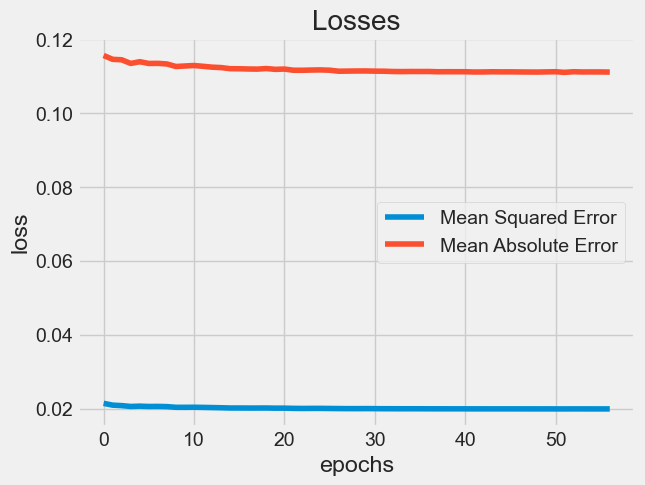

In [40]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [41]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts.head(50)

,Predictions,Actuals
0,177.967789,201.0
1,174.928833,222.0
2,178.125687,196.0
3,180.122009,210.0
4,182.160843,188.0
5,177.336288,198.0
6,174.759109,226.0
7,179.182587,240.0
8,185.534683,270.0
9,189.891479,281.0


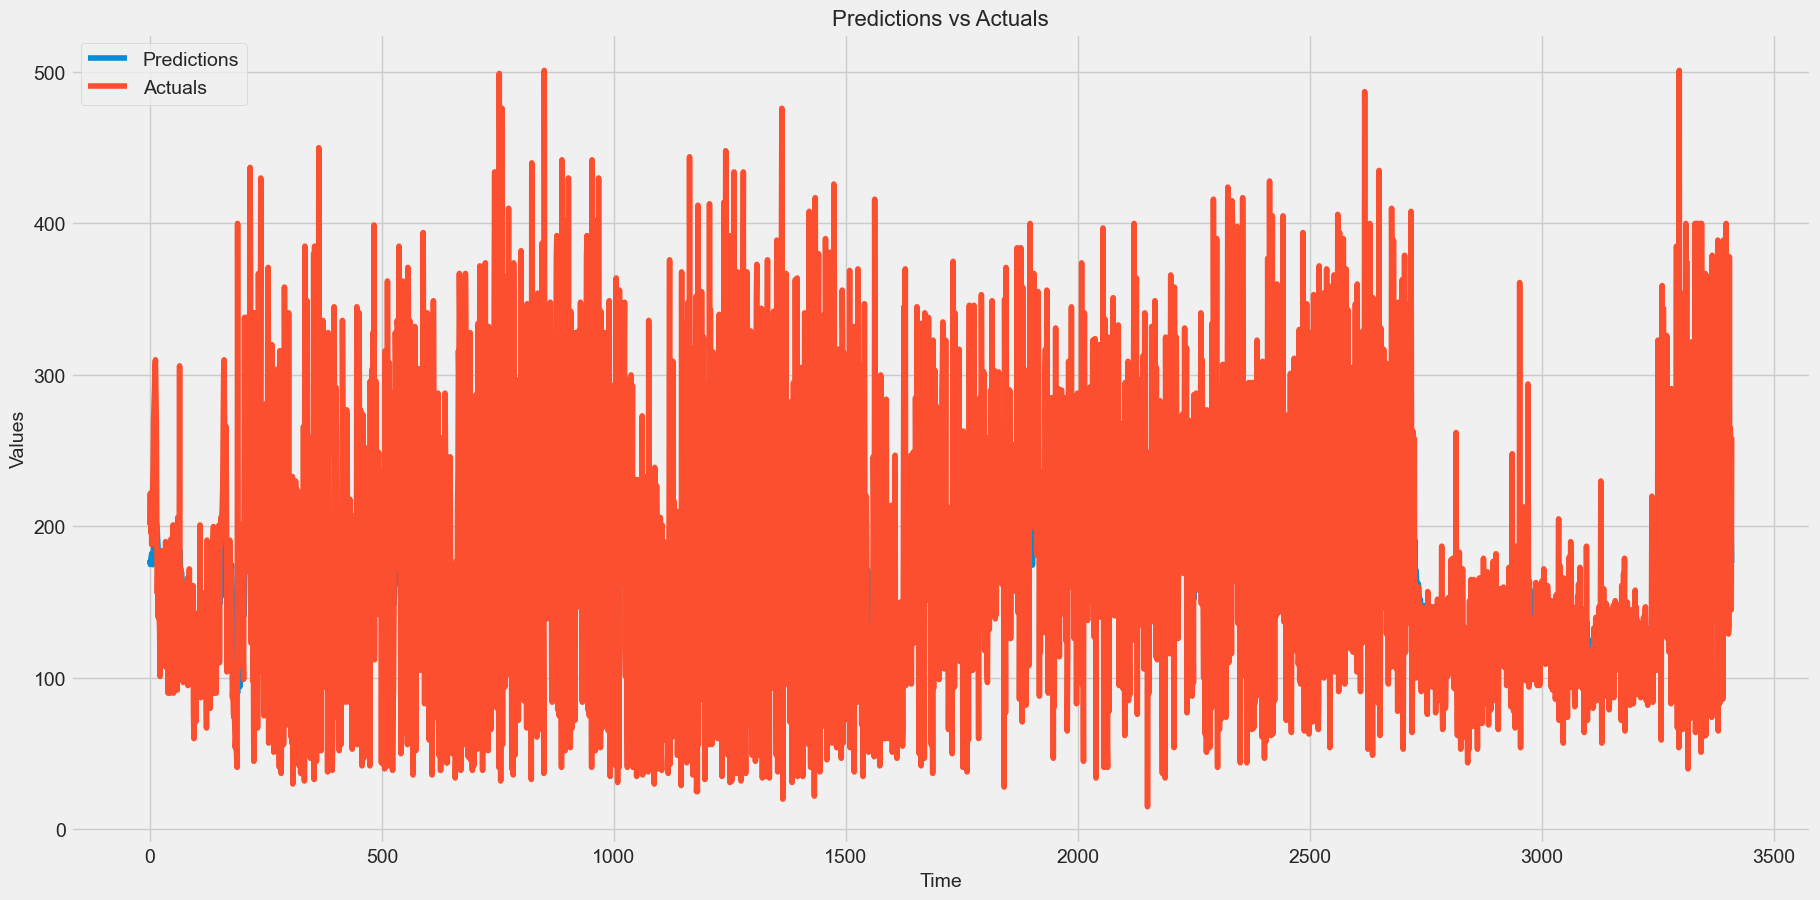

In [42]:
plt.figure(figsize=(20, 10))
plt.plot(preds_acts['Predictions'], label='Predictions')
plt.plot(preds_acts['Actuals'], label='Actuals')

# Adjust font size for legend, title, and labels
plt.legend(fontsize=14)
plt.title('Predictions vs Actuals', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Values', fontsize=14)

plt.show()

In [44]:
from datetime import timedelta

In [45]:
def insert_end(Xin, new_input):
    timestep = time_steps
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [46]:
df['id'].value_counts()

id
29    616
55    606
30    591
65    546
68    527
     ... 
6      65
32     62
14     58
69     51
40     31
Name: count, Length: 70, dtype: int64

In [47]:
test_id = df[df['id'] == 55]

# Convert 'value' to numeric, handle non-numeric values as NaN
test_id['value'] = pd.to_numeric(test_id['value'], errors='coerce')
test_id = test_id[test_id['value'].notnull()]

# Step 1: Combine 'date' and 'time' into a single 'datetime' column without specifying format
test_id['datetime'] = pd.to_datetime(
    test_id['date'] + ' ' + test_id['time'], errors='coerce'
)
test_id.drop(['val', 'date', 'time', 'id', 'Unnamed: 0'], axis=1, inplace=True)


# Check for NaNs in the DataFrame
print("Checking for NaNs in the dataset:")
print(test_id.isnull().sum())

# Step 5: Display the DataFrame with classifications
print(test_id[['datetime', 'value']])
test_id.set_index('datetime', inplace=True)

Checking for NaNs in the dataset:
code        0
value       0
datetime    0
dtype: int64
                 datetime  value
9827  1991-03-01 08:00:00    281
9828  1991-03-01 12:00:00    209
9829  1991-03-01 18:00:00    116
9830  1991-03-01 22:00:00    321
9831  1991-03-02 08:00:00    304
...                   ...    ...
10428 1991-07-26 22:00:00    111
10429 1991-07-27 08:00:00    201
10430 1991-07-27 12:00:00    121
10431 1991-07-27 18:00:00    116
10432 1991-07-27 22:00:00     99

[606 rows x 2 columns]


C:\Users\Hp\AppData\Local\Temp\ipykernel_5612\2958087260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_id['value'] = pd.to_numeric(test_id['value'], errors='coerce')


In [48]:
scaled_data_Test = scaler.fit_transform(np.array(test_id).reshape(-1, 1))

In [49]:
# scaled_data_Test = scaled_data_Test[ train_size-10: , 0:1 ]

In [50]:
scaled_data_Test.shape

(1212, 1)

In [52]:
# Convert to numpy array
x_test2 = np.array(x_train)

In [53]:
# future = 30  # Number of future predictions
# forecast = []
# timesteps = 30  # As per the model's expected input shape
# last_values = test_id[['value']].values[-timesteps:]  # Extract the last `timesteps` values
# Xin = last_values.reshape(1, timesteps, 1)  # Reshape to (1, timesteps, 1)
# dates = []

# # Ensure the last datetime value in the dataset
# last_datetime = test_id['datetime'].iloc[-1]

# for i in range(0, future):
#     # Predict the next value using the model
#     out = model.predict(Xin, batch_size=1)
#     forecast.append(out[0, 0])  # Append the prediction to the forecast list

#     # Update the input for the next prediction
#     new_value = out[0, 0]
#     Xin = np.append(Xin[:, 1:, :], [[[new_value]]], axis=1)  # Slide the window

#     # Calculate the next datetime value
#     new_date = last_datetime + timedelta(days=i + 1)  # Increment by 1 day
#     dates.append(new_date.strftime('%d-%m-%Y'))

# # Create a DataFrame with the forecast results
# forecast_df = pd.DataFrame({'date': dates, 'Forecasted': forecast})

# # Display the results
# print(forecast_df)

In [67]:
testtt=test_id['value']
testtt.head(90)

datetime
1991-03-01 08:00:00    281
1991-03-01 12:00:00    209
1991-03-01 18:00:00    116
1991-03-01 22:00:00    321
1991-03-02 08:00:00    304
                      ... 
1991-03-22 12:00:00     97
1991-03-22 18:00:00    260
1991-03-22 22:00:00     99
1991-03-23 08:00:00    280
1991-03-23 12:00:00    147
Name: value, Length: 90, dtype: int64

In [75]:
import json
file_path ="C:\\Users\\Hp\\Desktop\\tracking\\glucose_data.json"

# تحويل الفهرس (index) إلى عمود عادي وتحويل datetime إلى نص
testtt = test_id.reset_index()[['datetime', 'value']]
testtt['datetime'] = testtt['datetime'].astype(str)  # تحويل datetime إلى نص

# تحميل البيانات القديمة إن وجدت
try:
    with open(file_path, "r", encoding="utf-8") as f:
        existing_data = json.load(f)  # قراءة البيانات
        if not isinstance(existing_data, list):  
            existing_data = [existing_data]  
except (FileNotFoundError, json.JSONDecodeError):  
    existing_data = []  # إذا كان الملف غير موجود أو فارغًا

# تحويل الداتا إلى JSON ثم إضافتها
new_data = testtt.to_dict(orient="records")  
existing_data.extend(new_data)  

# حفظ الملف مجددًا
with open(file_path, "w", encoding="utf-8") as f:
    json.dump(existing_data, f, ensure_ascii=False, indent=4)

print("✅ تم تحديث glucose_data.json مع تحويل datetime إلى نص.")

✅ تم تحديث glucose_data.json مع تحويل datetime إلى نص.


In [54]:
from datetime import timedelta
import pandas as pd

future = 30 * 3  # 30 يوم × 3 قراءات يومية
forecast = []
Xin = x_test[-1:, :, :]
dates = []
codes = []

# تحويل الفهرس إلى datetime لضمان الدقة
test_id.index = pd.to_datetime(test_id.index)

for i in range(future):
    out = model.predict(Xin, batch_size=5)
    forecast.append(out[0, 0])  
    print(forecast)
    
    # تحديث المدخلات بالتنبؤ الجديد
    Xin = insert_end(Xin, out[0, 0])  
    
    # حساب التاريخ والوقت لكل 8 ساعات
    new_date = pd.to_datetime(test_id.index[-1]) + timedelta(hours=8 * (i + 1))
    dates.append(new_date.strftime('%d-%m-%Y %H:%M'))
    
    # العثور على أقرب `code` متاح لهذا التنبؤ
    closest_date = test_id.index[test_id.index.get_indexer([new_date], method='nearest')][0]
    closest_code = test_id.loc[closest_date, 'code']
    
    codes.append(closest_code)

# تحويل النتائج إلى DataFrame
forecast_df = pd.DataFrame({'Date': dates, 'Prediction': forecast, 'Code': codes})

# عرض النتيجة
print(forecast_df)


# # تحويل النتائج إلى DataFrame
# forecast_df = pd.DataFrame({'Date': dates, 'Prediction': forecast, 'Code': codes})
# print(forecast_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[0.3510549]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[0.3510549, 0.35081494]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[0.3510549, 0.35081494, 0.36184394]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[0.3510549, 0.35081494, 0.36184394, 0.36190194]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[0.3510549, 0.35081494, 0.36184394, 0.36190194, 0.34225163]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[0.3510549, 0.35081494, 0.36184394, 0.36190194, 0.34225163, 0.3462717]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[0.3510549, 0.35081494, 0.36184394, 0.36190194, 0.34225163, 0.3462717, 0.3544639]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[0.3510549, 0.35081494, 0.36184394, 0.36190194, 0.34225163, 0.3462717, 0.3544639, 0.34656867]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[0.3510549, 0.35081494, 0.36184394, 0.36190194, 0.34225163, 0.3462717, 0.3544639, 0.34656867, 0.33437935]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[0.3510549, 0.35081494, 0.36184394, 0.36190194, 0.34225163, 0.3462717, 0.3544639, 0.346

In [55]:
dates

['28-07-1991 06:00',
 '28-07-1991 14:00',
 '28-07-1991 22:00',
 '29-07-1991 06:00',
 '29-07-1991 14:00',
 '29-07-1991 22:00',
 '30-07-1991 06:00',
 '30-07-1991 14:00',
 '30-07-1991 22:00',
 '31-07-1991 06:00',
 '31-07-1991 14:00',
 '31-07-1991 22:00',
 '01-08-1991 06:00',
 '01-08-1991 14:00',
 '01-08-1991 22:00',
 '02-08-1991 06:00',
 '02-08-1991 14:00',
 '02-08-1991 22:00',
 '03-08-1991 06:00',
 '03-08-1991 14:00',
 '03-08-1991 22:00',
 '04-08-1991 06:00',
 '04-08-1991 14:00',
 '04-08-1991 22:00',
 '05-08-1991 06:00',
 '05-08-1991 14:00',
 '05-08-1991 22:00',
 '06-08-1991 06:00',
 '06-08-1991 14:00',
 '06-08-1991 22:00',
 '07-08-1991 06:00',
 '07-08-1991 14:00',
 '07-08-1991 22:00',
 '08-08-1991 06:00',
 '08-08-1991 14:00',
 '08-08-1991 22:00',
 '09-08-1991 06:00',
 '09-08-1991 14:00',
 '09-08-1991 22:00',
 '10-08-1991 06:00',
 '10-08-1991 14:00',
 '10-08-1991 22:00',
 '11-08-1991 06:00',
 '11-08-1991 14:00',
 '11-08-1991 22:00',
 '12-08-1991 06:00',
 '12-08-1991 14:00',
 '12-08-1991 

In [56]:
# تحويل القوائم إلى NumPy array ومعالجة القيم
forecasted_output = np.array(forecast).reshape(-1, 1)
forecasted_output = scaler.inverse_transform(forecasted_output)

# تحويل البيانات إلى DataFrame
forecasted_output_df = pd.DataFrame(forecasted_output, columns=["Forecasted"])
date_df = pd.DataFrame(dates, columns=["Date"])

# إضافة عمود `code`
code_column = pd.DataFrame({'Code': codes})

In [57]:
# دمج الأعمدة في DataFrame واحد
df_result = pd.concat([date_df, forecasted_output_df, code_column], axis=1)

# عرض النتيجة النهائية
print(df_result)

                Date  Forecasted  Code
0   28-07-1991 06:00  169.209305    48
1   28-07-1991 14:00  169.116196    48
2   28-07-1991 22:00  173.395447    48
3   29-07-1991 06:00  173.417953    48
4   29-07-1991 14:00  165.793625    48
..               ...         ...   ...
85  25-08-1991 14:00  156.713120    48
86  25-08-1991 22:00  156.711990    48
87  26-08-1991 06:00  156.710938    48
88  26-08-1991 14:00  156.710037    48
89  26-08-1991 22:00  156.709183    48

[90 rows x 3 columns]


In [58]:
df_result.head(20)

,Date,Forecasted,Code
0,28-07-1991 06:00,169.209305,48
1,28-07-1991 14:00,169.116196,48
2,28-07-1991 22:00,173.395447,48
3,29-07-1991 06:00,173.417953,48
4,29-07-1991 14:00,165.793625,48
5,29-07-1991 22:00,167.353409,48
6,30-07-1991 06:00,170.531998,48
7,30-07-1991 14:00,167.468643,48
8,30-07-1991 22:00,162.739182,48
9,31-07-1991 06:00,163.538132,48


In [127]:
import pandas as pd


# Check if the 'value' column is numeric
test_id['value'] = pd.to_numeric(test_id['value'], errors='coerce')

# Check if the 'Forecasted' column is numeric
df_result['Forecasted'] = pd.to_numeric(df_result['Forecasted'], errors='coerce')


In [96]:
print(predictions[:20])


[[178.18222]
 [177.74373]
 [178.14365]
 [176.04736]
 [176.21948]
 [175.5151 ]
 [176.19757]
 [178.18715]
 [180.41615]
 [184.9028 ]
 [189.58975]
 [194.12875]
 [198.29715]
 [201.45795]
 [202.4599 ]
 [201.96524]
 [196.5901 ]
 [190.17569]
 [184.77338]
 [178.55116]]


In [62]:
# Save the model to a file
model.save('C:\\Users\\Hp\\Desktop\\tracking\\gru_model.keras')  

In [63]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('C:\\Users\\Hp\\Desktop\\tracking\\gru_model.keras')

# Check the loaded model's summary to verify
loaded_model.summary()

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 16, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,696 (256.63 KB)

 Trainable params: 32,847 (128.31 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,849 (128.32 KB)